In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import flax.linen as nn

## Reproducing a 1D Gaussian Smoothing with a Flax Convolutional Layer

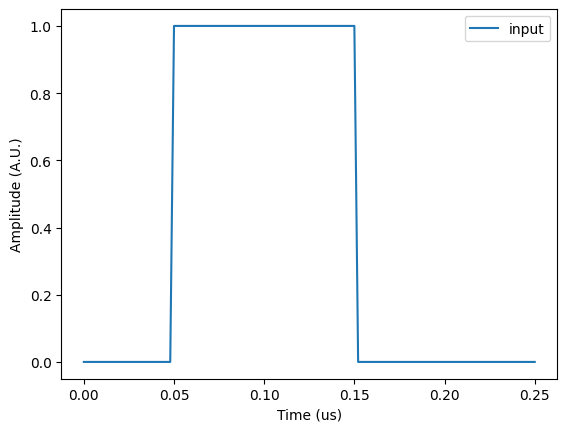

In [6]:
ts = jnp.linspace(0., 0.25, 121)
window_low = 0.05
window_high = 0.15

input_signal = jnp.heaviside(window_high - ts, 1.) * jnp.heaviside(ts - window_low, 0.)

plt.plot(ts, input_signal, label='input')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.show()

Gaussian Kernel: [0.00029089 0.00088366 0.00240203 0.00584277 0.01271754 0.02477038
 0.04317253 0.06733289 0.09397062 0.1173551  0.13114657 0.13114657
 0.1173551  0.09397062 0.06733289 0.04317253 0.02477038 0.01271754
 0.00584277 0.00240203 0.00088366]


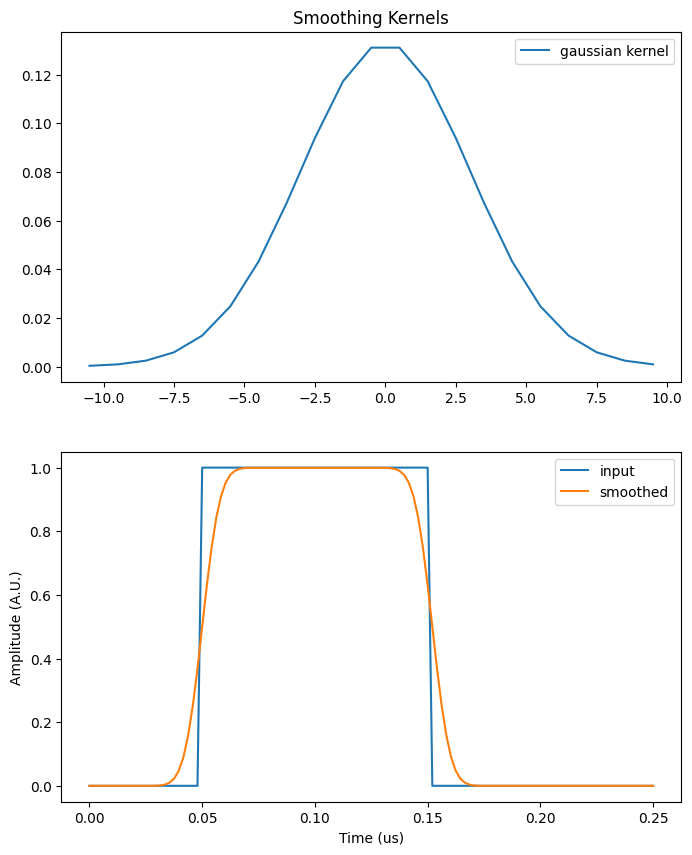

In [43]:
### Standard 1D Convolution with jnp.convolve ###

# Making the Gaussian Kernel
kernel_size = 21
small_window = jnp.arange(-0.5 * kernel_size, 0.5 * kernel_size)
gauss_kernel_mean = 0.
gauss_kernel_std = 3.
gauss_kernel = 1/(jnp.sqrt(2. * jnp.pi) * gauss_kernel_std) * jnp.exp(-(small_window - gauss_kernel_mean)**2 / (2 * gauss_kernel_std**2))

# Applying the Gaussian Kernel
smoothed_signal = jnp.convolve(input_signal, gauss_kernel, mode='same')

print(f"Gaussian Kernel: {gauss_kernel}")

fig, ax = plt.subplots(2, figsize=(8.0, 10.0))

ax[0].plot(small_window, gauss_kernel, label='gaussian kernel')
ax[0].set_title('Smoothing Kernels')
ax[0].legend()

ax[1].plot(ts, input_signal, label='input')
ax[1].plot(ts, smoothed_signal, label='smoothed')
ax[1].legend()
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Amplitude (A.U.)')

plt.show()

{'params': {'conv': {'kernel': Array([[[-0.10111883]],

       [[ 0.26225838]],

       [[ 0.14730695]],

       [[-0.23872223]],

       [[-0.36799508]],

       [[-0.25203863]],

       [[-0.33206874]],

       [[-0.29112867]],

       [[-0.18005617]],

       [[-0.09543367]],

       [[ 0.19167332]],

       [[-0.00394378]],

       [[-0.0157264 ]],

       [[ 0.20329572]],

       [[-0.19940756]]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}
{'params': {'conv': {'kernel': Array([[[0.00177274]],

       [[0.00543319]],

       [[0.01418983]],

       [[0.03158006]],

       [[0.05989098]],

       [[0.09678829]],

       [[0.13328984]],

       [[0.15641707]],

       [[0.15641707]],

       [[0.13328984]],

       [[0.09678829]],

       [[0.05989098]],

       [[0.03158006]],

       [[0.01418983]],

       [[0.00543319]]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}
(1, 121, 1)


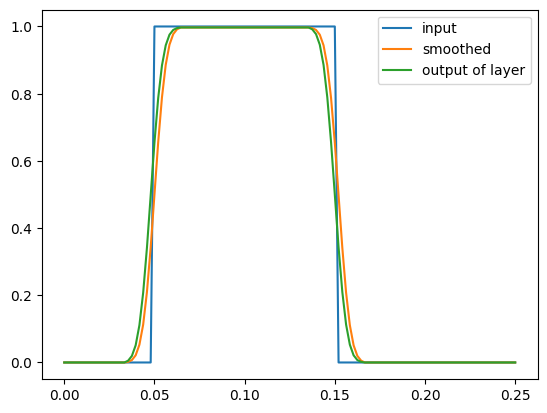

{'params': {'conv': {'bias': (1,), 'kernel': (15, 1, 1)}}}


In [42]:
### Now using Flax ###

class Conv1D(nn.Module):
    features: int
    kernel_size: int
    strides: int = 1
    padding: str = "SAME"

    def setup(self):
        self.conv = nn.Conv(features=self.features,
                            kernel_size=(self.kernel_size,),
                            strides=(self.strides,),
                            padding=self.padding)

    def __call__(self, x):
        return self.conv(x)

# Example usage
input_shape = (1, 121, 1)  # (batch_size, sequence_length, input_channels)
init_x = jnp.ones(input_shape)
x = input_signal.reshape(input_shape)

conv_layer = Conv1D(features=1, kernel_size=15)
params = conv_layer.init(jax.random.PRNGKey(0), init_x)

print(params)

applied_params = params
kernel_shape = applied_params["params"]["conv"]["kernel"].shape
applied_params["params"]["conv"]["kernel"] = gauss_kernel.reshape(kernel_shape)

print(applied_params)

output = conv_layer.apply(params, x)
print(output.shape)  # Output shape: (1, 8, 16) if padding='VALID'
cnn_output = output.flatten()

plt.plot(ts, input_signal, label='input')
plt.plot(ts, smoothed_signal, label='smoothed')
plt.plot(ts, cnn_output, label='output of layer')
plt.legend()
plt.show()

# Print parameter shapes
param_shapes = jax.tree_util.tree_map(jnp.shape, params)
print(param_shapes)

In [58]:
### Custom Fourier Convolutional Layer ###

from jax.numpy.fft import rfft, irfft

class FFTConv1D(nn.Module):
    in_channels: int
    out_channels: int
    modes1: int

    '''
    1D Fourier Convolutional Layer. It does FFT, Linear Transform, and Inverse FFT.
    '''

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return jnp.einsum("bix,iox->box", input, weights)

    @nn.compact
    def __call__(self, x):
        batchsize = x.shape[0]

        weights1 = self.param("weights1", nn.initializers.normal, (self.in_channels, self.out_channels, self.modes1))

        # Compute Fourier coefficients
        x_ft = rfft(x, axis=-1)

        # Multiply relevant Fourier modes
        # out_ft = jnp.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1)
        out_ft = jnp.zeros((batchsize, self.out_channels, self.modes1//2 + 1))
        print(x_ft.shape)
        out_ft[:, :, :self.modes1] = \
            self.compl_mul1d(x_ft[:, :, :self.modes1], weights1)
        # out_ft[:, :, -self.modes1:, :self.modes2] = \
        #     self.compl_mul2d(x_ft[:, :, -self.modes1:], self.weights2)

        x = irfft(out_ft, axis=-1)

        return x

# Example usage
input_shape = (1, 1, len(ts))  # (batch_size, sequence_length, input_channels)
x = jnp.ones(input_shape)

fft_layer = FFTConv1D(in_channels=1, out_channels=1, modes1=11)
params = fft_layer.init(jax.random.PRNGKey(0), x)

output = fft_layer.apply(params, x)
print(output.shape)  # Output shape: (1, 10, 16)

(1, 1, 61)


ValueError: Einstein sum subscript 'iox' does not contain the correct number of indices for operand 1.